In [155]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy
import seaborn as sns 
import matplotlib.pyplot as plt

In [156]:
dogs=np.load("dogs.npy")
cats=np.load("cats.npy")

In [157]:
dogs.shape, cats.shape

((1000, 50, 50, 3), (1000, 50, 50, 3))

In [158]:
input_data=[]
for i in range(2):
    if i==0:
        for j in range(len(dogs)):
            input_data.append(dogs[j])
    else :
        for k in range(len(cats)):
            input_data.append(cats[k])

In [159]:
len(input_data)

2000

In [160]:
input_data=np.array(input_data)

In [161]:
label=[]
for i in range(len(dogs)+len(cats)):
    if i > len(dogs):
        label.append(0)
    else :
        label.append(1)

In [162]:
label=np.array(label)

In [163]:
len(label)

2000

In [164]:
input_data=torch.FloatTensor(input_data)
label=torch.LongTensor(label)

In [165]:
input_data.shape

torch.Size([2000, 50, 50, 3])

In [166]:
input_data=input_data.transpose(1,3)

In [167]:
input_data.shape

torch.Size([2000, 3, 50, 50])

In [168]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
dataset = TensorDataset(input_data,label)

In [169]:
len(dataset)

2000

In [170]:
trainset, valset = torch.utils.data.random_split(dataset,[1600,400])
trainset,testset=torch.utils.data.random_split(trainset,[1200,400])

partition={'train':trainset,'val':valset,'test':testset}

torch.Size([3, 50, 50]) tensor(1)
torch.Size([50, 50, 3])


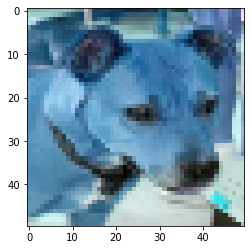

In [197]:
for i,j in testset:
    print(i.shape,j)
    i=i.transpose(0,2)
    print(i.shape)
    i=np.array(i)
    plt.imshow(i)
    break

In [239]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=3,
                            out_channels=32,
                            kernel_size=8,
                            stride=2,
                            padding=2) # 32 28 28
        self.conv2=nn.Conv2d(in_channels=32, 
                            out_channels=64,
                            kernel_size=6,
                            stride=1,
                            padding=2) # 64 60 64
        self.conv3=nn.Conv2d(in_channels=64,
                            out_channels=128,
                            kernel_size=3,
                            stride=1,
                            padding=1) # 25 30 128
        self.act=nn.ReLU()
        self.maxpool1=nn.MaxPool2d(kernel_size=2,
                                  stride=2)
        
        self.fc=nn.Linear(512,2)
    def forward(self,x):
        x=self.conv1(x)
        x=self.act(x)
        x=self.maxpool1(x)
        x=self.conv2(x)
        x=self.act(x)
        x=self.maxpool1(x)
        x=self.conv3(x)
        x=self.act(x)
        x=self.maxpool1(x)
        x=x.view(x.size(0),-1)
        #x=self.fc(x)
        return x

In [240]:
def dimension_check():
    net=CNN()
    x=torch.randn(1,3,50,50)
    y=net(x)
    print(y.shape)

In [241]:
dimension_check()

torch.Size([1, 512])


In [242]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() 

        # get the inputs
        inputs, labels = data
        #inputs = inputs.cuda()
        #labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [243]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            #images = images.cuda()
            #labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [244]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            #images = images.cuda()
            #labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [245]:
def experiment(partition, args):
  
    net = CNN()
    #net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [246]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size'] ## epoch, batch_size는 실험에 영향을 미치지 않는 변수이기 때문에 삭제

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './result1/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting) ## result라는 dic에 setting도 합치기 위함
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [247]:
!mkdir results_dc
!ls
!ls results_dc

mkdir: `results_dc' 디렉토리를 만들 수 없습니다: 파일이 있습니다
 1.npy				  'dog and cat -VER5.ipynb'   test1
 cat.npy			  'dog and cat -VER6.ipynb'   test1.zip
 cats.npy			   dog.npy		      train
 cats_img.npy			   dogs.npy		      train.zip
'dog and cat -VER1.ipynb'	   results_dc
'dog and cat -VER4 (Load).ipynb'   sampleSubmission.csv


In [250]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1/4_lr_l2"

# ====== Model Capacity ====== #

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 128
args.test_batch_size = 512

# ====== Experiment Variable ====== #
name_var1 = 'l2'
name_var2 = 'lr'
list_var1 = [0.00005]
list_var2 = [0.0015]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) ## args.name_var1 = var1 과 같은 말
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))

Namespace(epoch=10, exp_name='exp1/4_lr_l2', l2=5e-05, lr=0.0015, optim='Adam', test_batch_size=512, train_batch_size=128)
Epoch 0, Acc(train/val): 17.25/26.00, Loss(train/val) 3.45/2.20. Took 1.06 sec
Epoch 1, Acc(train/val): 36.92/45.00, Loss(train/val) 1.49/1.05. Took 1.01 sec
Epoch 2, Acc(train/val): 46.25/46.25, Loss(train/val) 0.97/0.89. Took 1.00 sec
Epoch 3, Acc(train/val): 48.00/50.00, Loss(train/val) 0.86/0.83. Took 1.00 sec
Epoch 4, Acc(train/val): 50.75/52.00, Loss(train/val) 0.80/0.80. Took 1.02 sec
Epoch 5, Acc(train/val): 51.92/52.50, Loss(train/val) 0.77/0.77. Took 1.08 sec
Epoch 6, Acc(train/val): 52.75/52.00, Loss(train/val) 0.75/0.76. Took 1.07 sec
Epoch 7, Acc(train/val): 55.58/54.50, Loss(train/val) 0.72/0.74. Took 1.02 sec
Epoch 8, Acc(train/val): 58.08/57.25, Loss(train/val) 0.70/0.73. Took 1.05 sec
Epoch 9, Acc(train/val): 59.17/57.75, Loss(train/val) 0.68/0.72. Took 1.05 sec
